In [91]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from glob import glob
import cv2
import torch
import torch.nn as nn
import yaml
import pandas as pd
from tqdm import tqdm
from PIL import Image
from torchvision import transforms


In [92]:
import argparse


opt=argparse.Namespace(**yaml.safe_load(open('../latest_config.yaml','r')))

In [98]:
opt.load_weights_folder="/home/master/tmp/mono_model/models/weights_199"
opt.load_weights_folder="/mnt/wext/msc_studies/monodepth_project/related_work/monodepth2/monodepth2/models/mono_640x192"
opt.max_depth=80
opt.batch_size=1

In [99]:
from monodepth2.trainer import Trainer


trainer = Trainer(opt)
trainer.set_eval()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
/home/master/.conda/envs/sc/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/master/.conda/envs/sc/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/master/.conda/envs/sc/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated s

loading model from folder /mnt/wext/msc_studies/monodepth_project/related_work/monodepth2/monodepth2/models/mono_640x192
Loading encoder weights...
Loading depth weights...
Loading pose_encoder weights...
Loading pose weights...
Cannot find Adam weights so Adam is randomly initialized
Training model named:
   mono_model
Models and tensorboard events files are saved to:
   /home/master/tmp
Training is using:
   cuda
len(train_filenames)=45200
len(train_filenames)=44570
len(val_filenames)=1776
len(val_filenames)=1746
Using split:
   eigen_full
There are 1 training items and 1 validation items



In [100]:
train_dataset = trainer.dataset(
            trainer.opt.data_path,
            trainer.train_filenames,
            trainer.opt.height,
            trainer.opt.width,
            trainer.opt.frame_ids,
            4,
            is_train=True,
            img_ext='.png',
        )
gen = torch.Generator()
gen.manual_seed(0)
random_idxs = torch.randperm(11_000, generator=gen)
ds = torch.utils.data.Subset(train_dataset, random_idxs)

In [101]:
from torch.utils.data import DataLoader

x = ds[0]
batch = next(
    iter(
        DataLoader(
            train_dataset,
            opt.batch_size,
            False,
            num_workers=0,
            pin_memory=True,
            drop_last=True,
        )
    )
)

In [102]:
outputs, losses = trainer.process_batch(batch)

/home/master/.conda/envs/sc/lib/python3.9/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [103]:
from monodepth2.evaluate_depth import load_networks_for_eval


encoder_dict, encoder, depth_decoder = load_networks_for_eval(opt)

/home/master/.conda/envs/sc/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [104]:
from monodepth2 import datasets
from torch.utils.data import DataLoader
from monodepth2.layers import disp_to_depth

dataset = datasets.KITTIRAWDataset(
    opt.data_path,
    trainer.train_filenames,
    encoder_dict["height"],
    encoder_dict["width"],
    [0],
    4,
    is_train=False,
    img_ext=".png",
)
dataloader = DataLoader(
    dataset,
    16,
    shuffle=False,
    num_workers=opt.num_workers,
    pin_memory=True,
    drop_last=False,
)


In [105]:
from monodepth2.evaluate_depth import batch_post_process_disparity
from monodepth2.vis_utils import disp_to_depth_full



pred_disps.shape, depths.shape

(torch.Size([2, 192, 640]), torch.Size([2, 1, 192, 640]))

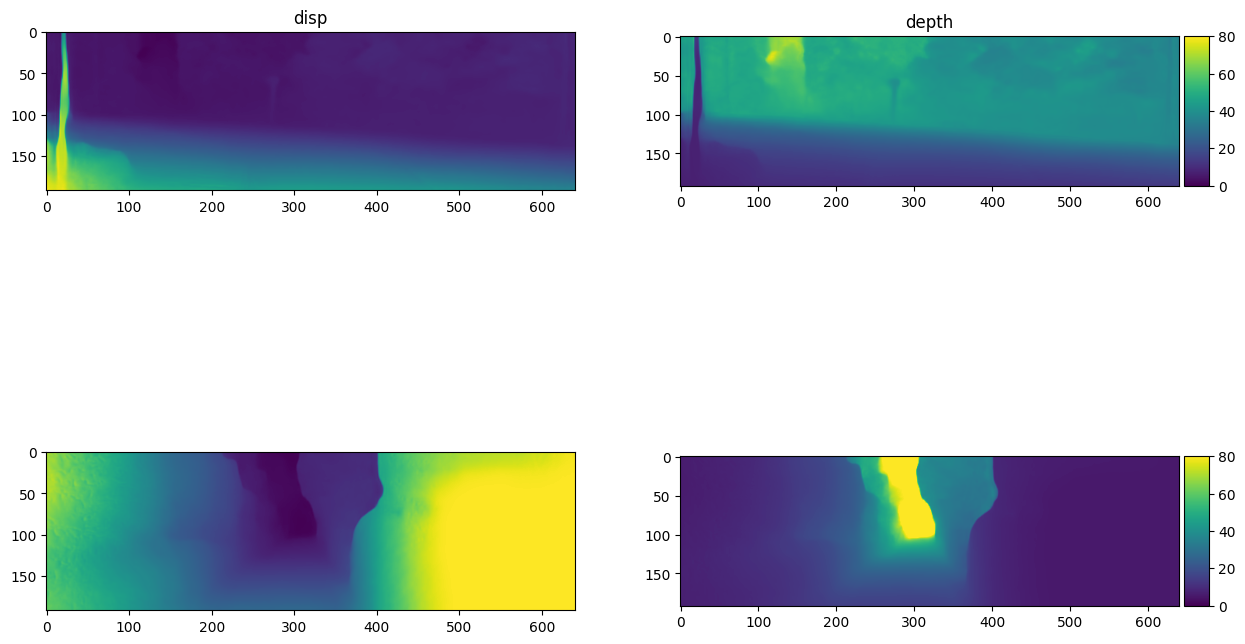

In [107]:
from layout_aware_monodepth.vis_utils import attach_colorbar

nrows = len(depths)
fig, axs = plt.subplots(nrows, 2, figsize=(15, 5*nrows))
for i in range(nrows):
    axs[i, 0].imshow(pred_disps[i])
    axs[i, 1].imshow(depths[i].squeeze())
    attach_colorbar(axs[i, 1], vmax=80)
    if i==0:
        axs[i, 0].set_title('disp')
        axs[i, 1].set_title('depth')

In [112]:
from layout_aware_monodepth.metrics import get_metrics

_, depths = disp_to_depth_full(outputs)
trainer.calc_metrics(
        outputs,
        batch
        # res, batch['depth'], max_depth=max_depth, min_depth=1e-3, crop_type=None, ds_name='kitti'
    )

{'abs_rel': 84.77491,
 'rmse': 29.294342,
 'mae': 26.91048,
 'sq_rel': 2716.4504,
 'rmse_log': 3.0677547,
 'delta1': 0.0004173429167632738,
 'delta2': 0.000741942963134709,
 'delta3': 0.001623000231857176,
 'log_10': 1.1830175,
 'silog': 141.11055775292388}

: 

In [69]:
from layout_aware_monodepth.pipeline_utils import create_tracking_exp


exp=create_tracking_exp(trainer.opt, exp_disabled=False)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/kirilllzaitsev/layout-aware-monodepth/24441ccf391542e0ace51a76c25b0570



In [70]:
exp.log_figure(
    "preds/sample",
    fig,
    step=0,
)

{'web': 'https://www.comet.com/api/image/download?imageId=035052d40f6a46979c3cf364816fbbed&experimentKey=24441ccf391542e0ace51a76c25b0570',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=035052d40f6a46979c3cf364816fbbed&experimentKey=24441ccf391542e0ace51a76c25b0570',
 'imageId': '035052d40f6a46979c3cf364816fbbed'}

In [87]:
exp.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kirilllzaitsev/layout-aware-monodepth/24441ccf391542e0ace51a76c25b0570
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     figures                      : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     installed packages           : 1
COMET INFO:     os packages                  : 1
COMET INFO:     source_code                  : 10 (75.90 KB)
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please 

In [32]:
pred_disps[0].max(), depth.max(), depth.min()

(7.990069, tensor(10.9145, device='cuda:0'), tensor(0.1000, device='cuda:0'))